In [1]:
import pandas as pd
import numpy as np
import json
import warnings
import tensorflow as tf
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, RepeatVector, LSTM, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping
import nltk
nltk.download('stopwords')
warnings.filterwarnings(action='ignore')

# Load and preprocess data
with open("dataset.json", "r") as f:
    data = json.load(f)["dataset"]
data = pd.DataFrame(data)
data['instruction'] = data['instruction'].str.lower()

# Remove stopwords
stop_words = set(stopwords.words("english"))
data['instruction'] = data['instruction'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

X = data['instruction']
y = data['actions'].apply(lambda x: " ".join(map(str, x)))


# Load GloVe embeddings
embedding_dim = 100
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Convert instruction to embeddings
def get_task_embeddings(tasks):
    task_embeddings = []
    for task in tasks:
        words = task.lower().split()
        word_embeddings = [embeddings_index.get(word, np.zeros(embedding_dim)) for word in words]
        avg = np.mean(word_embeddings, axis=0)
        if avg.shape != (embedding_dim,):
            avg = np.zeros(embedding_dim)
        task_embeddings.append(avg)
    return np.array(task_embeddings)

task_embeddings = get_task_embeddings(X)

# Encode labels
ohe = OneHotEncoder()
y_encoded = ohe.fit_transform(y.values.reshape(-1, 1)).toarray()
action_dim = y_encoded.shape[1]


# Pad sequences (repeat action for seq learning - simplification)
actions = np.array([np.tile(row, (1, 1)) for row in y_encoded])
actions = np.array(actions)
 
 #train_validation split
from sklearn.model_selection import train_test_split
import numpy as np

train_data, val_data, train_labels, val_labels = train_test_split(
     task_embeddings, actions, test_size=0.25, random_state=42
 )



# Model
model = Sequential([
    Input(shape=(embedding_dim,)),
    RepeatVector(1),
    LSTM(128, return_sequences=True),
    TimeDistributed(Dense(action_dim, activation='softmax'))
])
early_stop = EarlyStopping(
    monitor='val_loss',      
    patience=5,              
    restore_best_weights=True  
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(task_embeddings, actions,validation_data=(val_data, val_labels),  callbacks=[early_stop],epochs=100)

ModuleNotFoundError: No module named 'tensorflow'

In [79]:
task_embeddings[15].shape

(100,)

[array(['forward', 'go_to_corridor', 'go_to_door', 'go_to_lift',
        'go_to_table', 'left', 'reverse', 'right', 'roam_room', 'start',
        'stop'], dtype=object)]

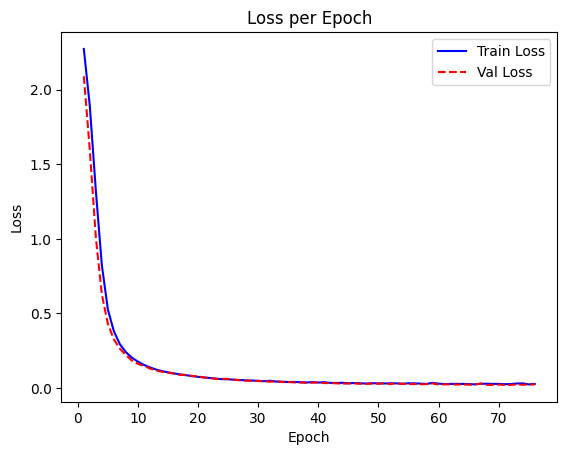

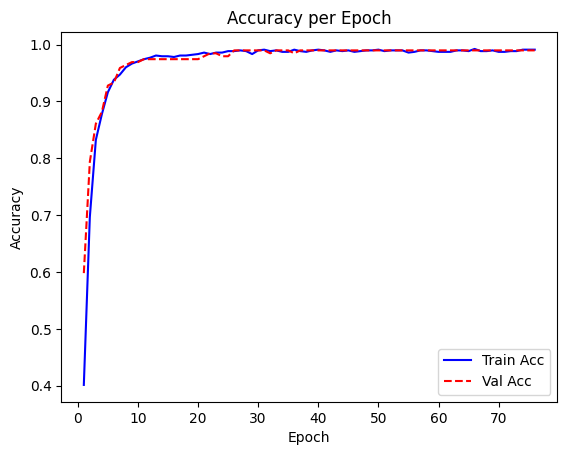

In [80]:

# Plot results
import matplotlib.pyplot as plt
epochs = range(1, len(history.history['loss']) + 1)

plt.plot(epochs, history.history['loss'], 'b-', label='Train Loss')
plt.plot(epochs, history.history['val_loss'], 'r--', label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, history.history['accuracy'], 'b-', label='Train Acc')
plt.plot(epochs, history.history['val_accuracy'], 'r--', label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [88]:
# predictions
y_pred=model.predict(val_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [89]:
y_pred = y_pred.argmax(axis=1)
y_true = val_labels.argmax(axis=1)


In [90]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true, y_pred)
print("Test accuracy (sklearn): {:.4f}".format(acc))


Test accuracy (sklearn): 1.0000


In [ ]:
model.save("raghav.h5")

In [91]:
results = model.evaluate(val_data, val_labels, batch_size=32)
print("Keras evaluation:", results)
# results[0] = loss, results[1] = accuracy (if metrics=['accuracy'])


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9872 - loss: 0.0308 
Keras evaluation: [0.021221861243247986, 0.9896907210350037]


In [69]:
zz =["keep moving"]
xz=get_task_embeddings(zz)
xz.shape

(1, 100)

In [71]:
prediction=model.predict(xz)
predicted_class = np.argmax(prediction)
predicted_class


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


0

In [67]:
ohe.categories_

[array(['forward', 'go_to_corridor', 'go_to_door', 'go_to_lift',
        'go_to_table', 'left', 'reverse', 'right', 'roam_room', 'start',
        'stop'], dtype=object)]